In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Première petite analyse en machine learning 

C'est une petite routine que j'aime bien mettre en route quand je commence un projet.
Pour l'instant rien de très rigoureux mais pas mal pour commencer à s'ammuser.

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

Je ne sais pas si c'est une bonne chose à faire mais les warnings m'embêtent donc : 

In [3]:
import warnings
warnings.filterwarnings('ignore')

Les classifiers classiques qu'on se proposent d'utiliser dans un premier temps :

In [4]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.cross_validation import KFold

## Les données 

On va travailer dans un premier temps avec la table "dim_patient_preoperatoire.csv.csv" 

In [5]:
dim_patient_preoperatoire=pd.read_csv("dim_patient_preoperatoire.csv") ; dim_patient_preoperatoire.shape

(428, 41)

In [6]:
dim_patient_preoperatoire.head()

,Unnamed: 0,numero,LOS_first_ventilation,LOS_total_ventilation,immediate_extubation,secondary_intubation,time_to_secondary_intubation,secondary_ECMO,delai_recours_ECMO,Cause_ECMO_secondaire,...,P_F_H0,PGD_H0,P_F_end_surgery,PGD_end_surgery,time_last_PF,PDG_h24,PGD_h48,PGD3,date_de_deces,Survival_days_27_10_2018
0,0,1.0,16.0,16.0,0.0,0.0,NaN,0.0,NaN,NaN,...,241.53846153846152,E,210.0,2,192.0,1.0,1.0,1.0,NaN,2463
1,1,2.0,0.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,...,NF,NF,304.0,1,158.0,0.0,0.0,0.0,NaN,2461
2,2,3.0,3.0,3.0,0.0,0.0,NaN,0.0,NaN,NaN,...,103.75,E,222.0,E,141.0,1.0,0.0,1.0,NaN,2457
3,3,4.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,...,286,2,453.0,1,102.0,0.0,0.0,0.0,2016-02-22,1499
4,4,5.0,14.0,14.0,0.0,0.0,NaN,0.0,NaN,NaN,...,330,1,192.0,3,124.0,1.0,1.0,1.0,NaN,2451


Les variables cibles sont 'immediate_extubation' et 'secondary_intubation'

In [7]:
dim_patient_preoperatoire.loc[:,['immediate_extubation','secondary_intubation']].head()

,immediate_extubation,secondary_intubation
0,NaN,0.0
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0


In [8]:
dim_patient_preoperatoire.loc[:,['immediate_extubation','secondary_intubation']].describe()

,immediate_extubation,secondary_intubation
count,0.0,408.000000
mean,NaN,0.122549
std,NaN,0.328321
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000
max,NaN,1.000000


Regardons quel genre de variables nous avons pour jouer

In [9]:
dim_patient_preoperatoire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 41 columns):
Unnamed: 0                            428 non-null int64
numero                                411 non-null float64
LOS_first_ventilation                 410 non-null float64
LOS_total_ventilation                 410 non-null float64
 immediate_extubation                 410 non-null float64
secondary_intubation                  408 non-null float64
time_to_secondary_intubation          142 non-null float64
secondary_ECMO                        408 non-null float64
delai_recours_ECMO                    120 non-null float64
Cause_ECMO_secondaire                 120 non-null float64
postoperative_vasopressive_support    408 non-null float64
ACFA                                  408 non-null float64
PRBC_postop                           408 non-null float64
FFP_postop                            408 non-null float64
Platelets_postop                      408 non-null float64
CVA         

Il y a au moins 5 colonnes 'object' (càd des string)... On se propose de voir leur tête :

In [10]:
dim_patient_preoperatoire.select_dtypes(include=['object']).head()

,P_F_H0,PGD_H0,PGD_end_surgery,date_de_deces,Survival_days_27_10_2018
0,241.53846153846152,E,2,NaN,2463
1,NF,NF,1,NaN,2461
2,103.75,E,E,NaN,2457
3,286,2,1,2016-02-22,1499
4,330,1,3,NaN,2451


Clairment il y a pleins de choses interessantes à faire là mais je le ferai plus tard 

On regarde tout de suite les corrélations très fortes pour cette table : (comme il y a beaucoup de variable on filtre les corrélations plus négigeables ...)

In [11]:
dimpa_corr=dim_patient_preoperatoire.corr()
dimpa_corr_tres_forte=dimpa_corr[(dimpa_corr<-0.75) | ((dimpa_corr>=0.75) & (dimpa_corr<1))].dropna(how='all').dropna(axis=1,how='all')
dimpa_corr_tres_forte.shape

(11, 11)

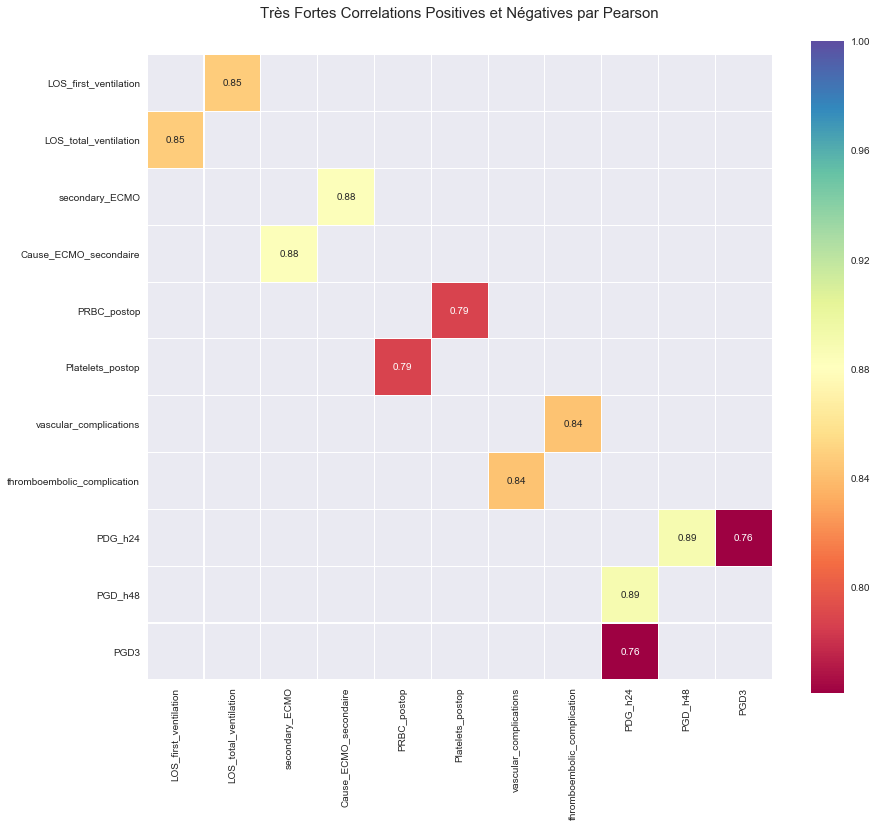

In [12]:
colormap = plt.cm.Spectral
plt.figure(figsize=(14,12))
plt.title('Très Fortes Correlations Positives et Négatives par Pearson', y=1.05, size=15)
sns.heatmap(dimpa_corr_tres_forte,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Mais on oublie pas qu'il y a encore plus de correlations fortes au sens de Pearson :

In [13]:
dimpa_corr_forte=dimpa_corr[(dimpa_corr<-0.5) | ((dimpa_corr>=0.5) & (dimpa_corr<1))].dropna(how='all').dropna(axis=1,how='all')
dimpa_corr_forte.shape

(30, 30)

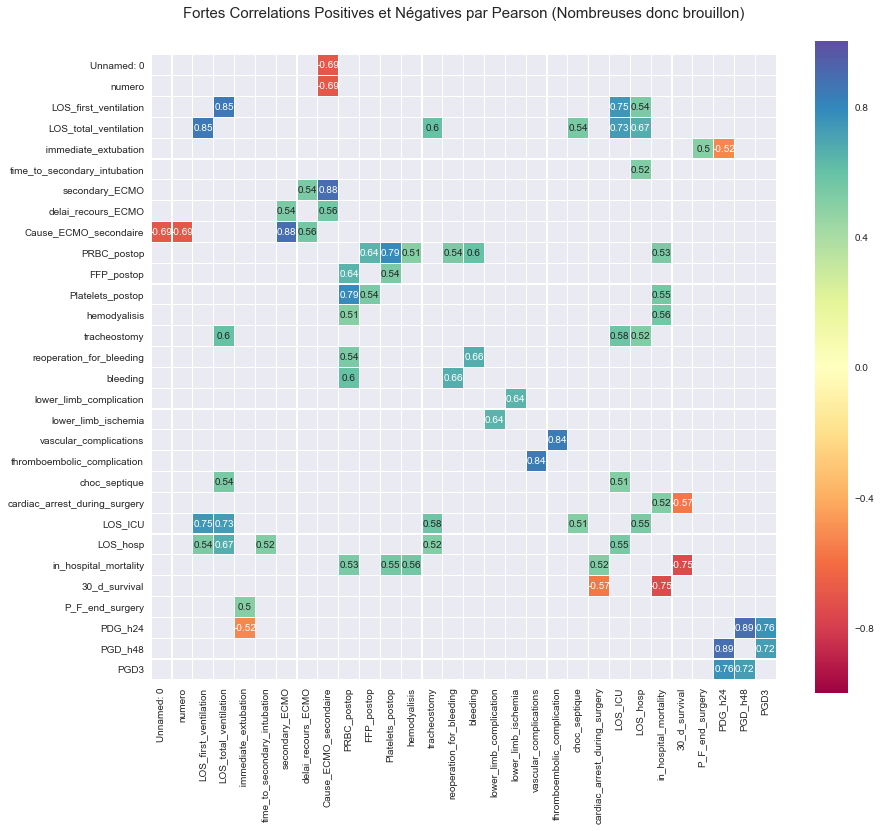

In [14]:
colormap = plt.cm.Spectral
plt.figure(figsize=(14,12))
plt.title('Fortes Correlations Positives et Négatives par Pearson (Nombreuses donc brouillon)', y=1.05, size=15)
sns.heatmap(dimpa_corr_forte,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Il faudrait analyser ces corrélations !!!


## Comparaison classifieurs 

On avait vu qu'il y avait beaucoup de type "object" donc on se propose de les enlever puis enlever les données "manquantes" :

In [15]:
dim_patient_preoperatoire_so=dim_patient_preoperatoire.select_dtypes(exclude=['object'])
dim_patient_preoperatoire_so.shape

(428, 36)

In [16]:
dim_patient_preoperatoire_so=dim_patient_preoperatoire_so.dropna()
dim_patient_preoperatoire_so.shape

(111, 36)

#### Oulala si on enlève les Nan il y a plus rien !! Très problèmatique !

## Ici on pique la data préparation de Guillaume

df_Bloc = pd.read_csv('clean_Bloc_files.csv', sep=',', index_col =[36,37], engine='c')

df_donor = pd.read_csv('dim_donor.csv', sep=',', index_col =0, engine='c')

df_patient = pd.read_csv('dim_patient.csv', sep=',', index_col =0, engine='c')

[df_patient, df_donor]

df_global = pd.concat([df_patient, df_donor], axis=1)#, sort = False)

col_date_lst = ['date_transplantation', 'date_sortie_bloc','heure_arrivee_rea','date_de_deces']
col_post_lst = ['time_to_secondary_intubation']

col_to_delete_lst = []
col_to_delete_lst.extend(col_date_lst)
col_to_delete_lst.extend(col_post_lst)
col_to_delete_lst

df_global.drop(col_to_delete_lst, axis=1, inplace=True)

df_global = df_global.loc[df_global['immediate_extubation'] == 1]
col_to_delete_lst = ['immediate_extubation','los_total_ventilation']
df_global.drop(col_to_delete_lst, axis=1, inplace=True)

df_y = df_global['secondary_intubation']
col_to_delete_lst = ['secondary_intubation']
df_X = df_global.drop(col_to_delete_lst, axis=1)

df_X.replace(to_replace=['?', 'NF'], value=pd.np.nan, inplace=True)
df_X.replace(to_replace=['E'], value=-1, inplace=True)
df_X.fillna(value=pd.np.nan, inplace=True)

In [17]:
dim_patient_preoperatoire_so.columns

Index(['Unnamed: 0', 'numero', 'LOS_first_ventilation',
       'LOS_total_ventilation', ' immediate_extubation',
       'secondary_intubation', 'time_to_secondary_intubation',
       'secondary_ECMO', 'delai_recours_ECMO', 'Cause_ECMO_secondaire',
       'postoperative_vasopressive_support', 'ACFA', 'PRBC_postop',
       'FFP_postop', 'Platelets_postop', 'CVA', 'hemodyalisis', 'tracheostomy',
       'reoperation_for_bleeding', 'bleeding', 'lower_limb_complication',
       'lower_limb_ischemia', 'scarpa_complication', 'vascular_complications',
       'thromboembolic_complication', 'choc_septique',
       'cardiac_arrest_during_surgery', 'LOS_ICU', 'LOS_hosp',
       'in_hospital_mortality', '30_d_survival', 'P_F_end_surgery',
       'time_last_PF', 'PDG_h24', 'PGD_h48', 'PGD3'],
      dtype='object')

Attention il y a un espace au début de  ' immediate_extubation' !!!

### Quels sont les données avec lesquelles on travail ? : Ici Train et Test split !
(On pose des seeds pour la reproductibilité priliminaire ...)

In [18]:

X=dim_patient_preoperatoire_so.drop([' immediate_extubation','secondary_intubation'], 1) #On enlève les variables cibles 
Y=dim_patient_preoperatoire_so.loc[:,[' immediate_extubation']] #avant de regarder 'secondary_intubation'


X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.33, random_state=42)




x_train=X_train.fillna(value=0).values
x_test=X_test.fillna(value=0).values

y_train=Y_train.fillna(value=0).values
y_test= Y_test.fillna(value=0).values

(P.S. : je me rend compte que mes notations sont des mauvaises pratiques ... Je mets un grand X quand c'est une df et un petit x quand je convertis en array ...)

Des données utiles pour plus tard

In [19]:

cols = X_train.columns.values  #On a besoin des colonnes pour plus tard 
                                # On observe le grand X et pas le petit x ...

ntrain = x_train.shape[0]

ntest = x_test.shape[0]

seed_fix = 5                   # Pour reproduire les résultats

A partir d'ici on va créer des classes pour ne pas avoir à recopier trop souvent les mêmes choses et faciliter l'extension si on veux faire du stacking.

In [20]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    

In [21]:

NFOLDS = 5 
kf = KFold(ntrain, n_folds= NFOLDS, random_state=seed_fix)



def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Les paramètres pour chaque classifieurs 

Random Forest

In [22]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

Extra Trees 


In [23]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}


AdaBoost 

In [24]:
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}


Gradient Boosting

In [25]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

Les modèles utilisés :

In [26]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed_fix , params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed_fix, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed_fix , params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=seed_fix, params=gb_params)

Là on peut enfin lancer nos modèles !

In [27]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost

print("Apprentissage terminé :D")

Apprentissage terminé :D


On récupère l'importance des variables et on va les comparer pour une meilleure interprétation des modèles :

In [28]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

#On met plutot dans un dataFrame
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest Importance des features': rf_feature,
     'Extra Trees Importance des features': et_feature,
      'AdaBoost Importance des features': ada_feature,
    'Gradient Boost Importance des features': gb_feature
    })

Et les prédictions respectives :

## Les Réslutats de nos prédictions !

In [29]:
rf_pred=rf.predict(X_test)
et_pred=et.predict(X_test)
ada_pred=ada.predict(X_test)
gb_pred=gb.predict(X_test)

In [30]:
from sklearn import metrics
print(metrics.classification_report(rf_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.88      0.91      0.89        23
        1.0       0.85      0.79      0.81        14

avg / total       0.86      0.86      0.86        37



In [31]:
print(metrics.classification_report(et_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.88      0.72      0.79        29
        1.0       0.38      0.62      0.48         8

avg / total       0.77      0.70      0.72        37



In [32]:
print(metrics.classification_report(ada_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        24
        1.0       0.85      0.85      0.85        13

avg / total       0.89      0.89      0.89        37



In [ ]:
print(metrics.classification_report(gb_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.83      0.95      0.89        21
        1.0       0.92      0.75      0.83        16

avg / total       0.87      0.86      0.86        37



# Visualisation des Résultats

Bon là j'ai un peu modifié un graph que j'aime bien qui aide à visualiser ce qui se passe pour chaque classifieur :

Le feature_importances_ est en fait le coefficiednt de Gini ( ou Gini importance) :

En tous cas pour :

-DecisionTreeClassifier




https://fr.wikipedia.org/wiki/Coefficient_de_Gini
https://stats.stackexchange.com/questions/92419/relative-importance-of-a-set-of-predictors-in-a-random-forests-classification-in/92843#92843
https://homes.cs.washington.edu/~shapiro/EE596/notes/InfoGain.pdf

## Random Forest

In [ ]:
trace = go.Scatter(x = feature_dataframe['features'].values,
    y = feature_dataframe['Random Forest Importance des features'].values,
    
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Importance des features',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Importance des features',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='scatter2010')



## Extra Trees

In [ ]:
trace = go.Scatter(
    y = feature_dataframe['Extra Trees Importance des features'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Importance des features',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Importance des features',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


## AdaBoost

In [ ]:
trace = go.Scatter(
    y = feature_dataframe['AdaBoost Importance des features'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Importance des features',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Importance des features',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


## Gradient Boost

In [ ]:
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost Importance des features'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Importance des features',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Importance des features',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')